In [1]:
import gensim
import pandas as pd
from gensim.utils import simple_preprocess
import nltk
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict 
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec

In [2]:
# reading in data
data = pd.read_csv("853.csv")

# print head 
data.head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny
0,Who knew the Swiss had a navy?,1.675661,0.018367,1816,946,513,357
1,Weapons down. It's the Swiss.,1.672884,0.020759,1394,721,408,265
2,"Wow, and that’s just the tip of the Jarlsberg!",1.643323,0.018380,1685,886,512,286
3,All we need now is to find a port,1.639823,0.012828,3837,2151,917,769
4,We must be directly over where Wisconsin used ...,1.638809,0.022989,1041,542,333,166


In [3]:
# remove columns
df = data.drop(columns=['mean', 'precision', 'votes', 'not_funny', 'somewhat_funny', 'funny'], axis=1)

df.head()

,caption
0,Who knew the Swiss had a navy?
1,Weapons down. It's the Swiss.
2,"Wow, and that’s just the tip of the Jarlsberg!"
3,All we need now is to find a port
4,We must be directly over where Wisconsin used ...


In [4]:
# shape of dataframe
df.shape

(4680, 1)

In [5]:
# list
captions = df.caption.tolist()
captions[0]

'Who knew the Swiss had a navy?'

In [6]:
# stopwords
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

In [7]:
# Remove punctuation
df['caption_processed'] = \
df['caption'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['caption_processed'] = \
df['caption_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df.head()

,caption,caption_processed
0,Who knew the Swiss had a navy?,who knew the swiss had a navy
1,Weapons down. It's the Swiss.,weapons down it's the swiss
2,"Wow, and that’s just the tip of the Jarlsberg!",wow and that’s just the tip of the jarlsberg
3,All we need now is to find a port,all we need now is to find a port
4,We must be directly over where Wisconsin used ...,we must be directly over where wisconsin used ...


In [8]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(df.caption_processed)
print(lemmatized_texts)

['know swiss navy', 'weapon swiss', '’ just tip', 'need now find port', 'directly wisconsin use', 'aged alright', 'go need big board', '’re go need big board', 'sea muenster', 'pair well great white', 'let hope just tip', 'worry swiss neutral', 'careful man ’re un - charcuterie water', 'perfect great white', 'think ’re go need more cracker', 'look enter costco water', 'careful boy only tip', 'careful just tip', 'gouda', 'careful boy sharp one', 'careful man sharp', 'let pass brie', 'boy go need big board', 'get close', 'call béchamel', 'tell muenster roam sea', 'never say picnic', 'look ’ sharkuterie', 'thar blow muenster deep', 'take cutter', 'wait attack neutral', 'white cheese night dinner delight white cheese morning high cholesterol warning', 'look first take run', 'think go need big cheese board', '’ swiss else see first', 'next time let just go costco', '’re go need big cracker', 'care flee tyranny sandwich island', 'think go need more robust cabernet', 'man island cheese stand 

In [9]:
# removing stopwords and tokenizing
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True)
        final.append(new)
    return(final)
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]

data_words = gen_words(lemmatized_texts)
data_words = remove_stopwords(data_words)
print(data_words)

[['know', 'swiss', 'navy'], ['weapon', 'swiss'], ['tip'], ['need', 'find', 'port'], ['directly', 'wisconsin', 'use'], ['aged', 'alright'], ['need', 'big', 'board'], ['need', 'big', 'board'], ['sea', 'muenster'], ['pair', 'great', 'white'], ['let', 'hope', 'tip'], ['worry', 'swiss', 'neutral'], ['careful', 'man', 'un', 'charcuterie', 'water'], ['perfect', 'great', 'white'], ['think', 'need', 'cracker'], ['look', 'enter', 'costco', 'water'], ['careful', 'boy', 'tip'], ['careful', 'tip'], ['gouda'], ['careful', 'boy', 'sharp'], ['careful', 'man', 'sharp'], ['let', 'pass', 'brie'], ['boy', 'need', 'big', 'board'], ['close'], ['bechamel'], ['tell', 'muenster', 'roam', 'sea'], ['picnic'], ['look', 'sharkuterie'], ['thar', 'blow', 'muenster', 'deep'], ['cutter'], ['wait', 'attack', 'neutral'], ['white', 'cheese', 'night', 'dinner', 'delight', 'white', 'cheese', 'morning', 'high', 'cholesterol', 'warning'], ['look', 'run'], ['think', 'need', 'big', 'cheese', 'board'], ['swiss'], ['time', 'let'

In [26]:
# word2vec model
model = Word2Vec(
    window=5,
    min_count=1,
    workers=4,
    sg = 1
)

In [27]:
# build vocab
model.build_vocab(data_words, progress_per=1000)

In [28]:
# train model
model.train(data_words, total_examples=model.corpus_count, epochs=model.epochs)

(63688, 84815)

In [29]:
model.wv.most_similar("weapon")

[('eat', 0.9953675270080566),
 ('shark', 0.9951784610748291),
 ('boy', 0.995082437992096),
 ('remember', 0.9950302839279175),
 ('slice', 0.9949997067451477),
 ('guy', 0.9949046969413757),
 ('cheese', 0.9947827458381653),
 ('sharp', 0.9947572946548462),
 ('mean', 0.9946931004524231),
 ('time', 0.9946370124816895)]

In [30]:
model.wv.most_similar("swiss")

[('slice', 0.9979737997055054),
 ('tell', 0.9976603388786316),
 ('brie', 0.9976284503936768),
 ('ready', 0.9976092576980591),
 ('remember', 0.9975900650024414),
 ('good', 0.9975769519805908),
 ('charcuterie', 0.99757319688797),
 ('cheese', 0.9975699186325073),
 ('let', 0.9975615739822388),
 ('hope', 0.9974939823150635)]

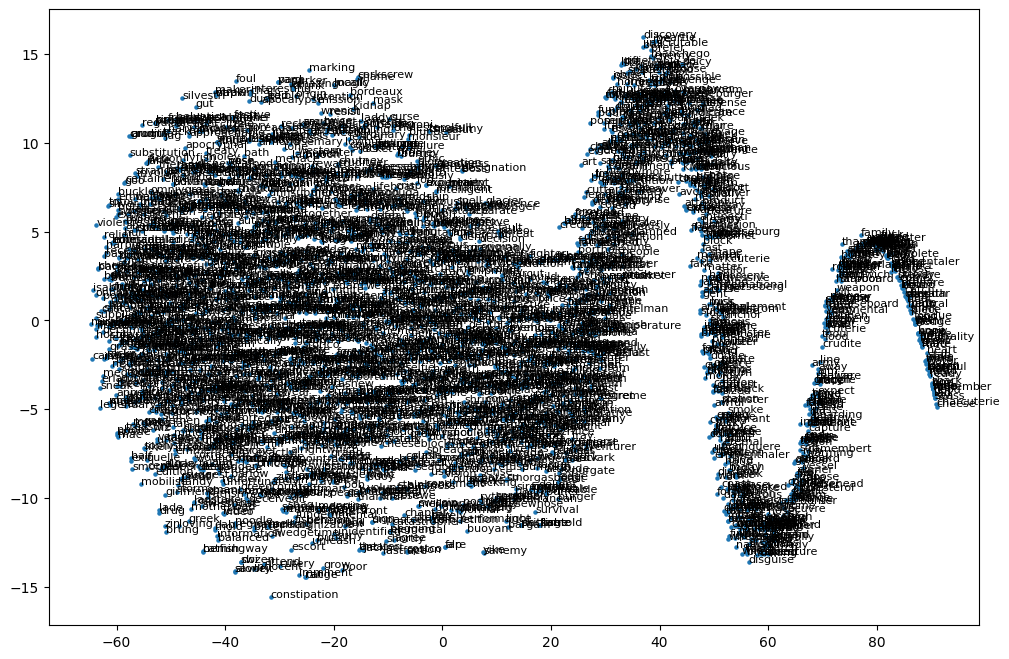

In [35]:
# Get word vectors and corresponding words
word_vectors = model.wv.vectors
words = model.wv.index_to_key

# Set the number of dimensions for visualization
num_dimensions = 2

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=num_dimensions, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o', s=5)

# Annotate the points with corresponding words
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), size=8)

# Show the plot
plt.show()

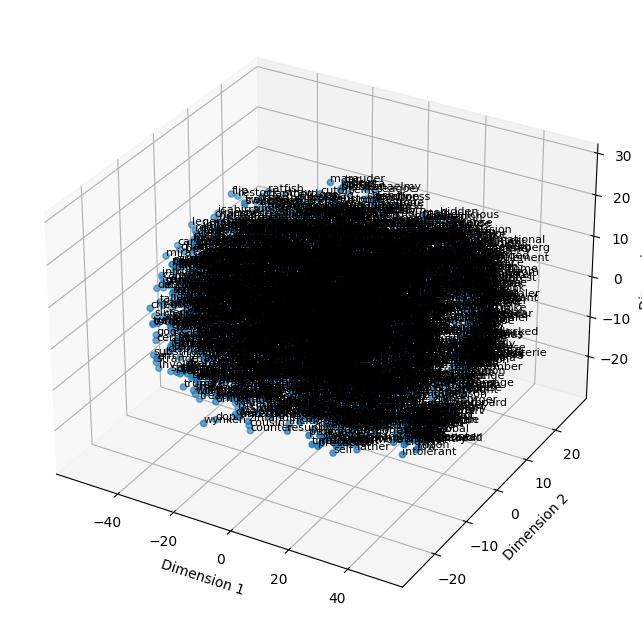

In [42]:
from mpl_toolkits.mplot3d import Axes3D

# Get word vectors and corresponding words
word_vectors = model.wv.vectors
words = model.wv.index_to_key

# Set the number of dimensions for visualization
num_dimensions = 3  # Set to 3 for 3D visualization

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=num_dimensions, random_state=42)
word_vectors_3d = tsne.fit_transform(word_vectors)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the word vectors
ax.scatter(word_vectors_3d[:, 0], word_vectors_3d[:, 1], word_vectors_3d[:, 2], marker='o', s=20)

# Annotate the points with corresponding words
for i, word in enumerate(words):
    ax.text(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2], word, size=8)

# Set labels for each axis
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Show the 3D plot
plt.show()